# SIR models without the calculus

**Benjamin Vincent, University of Dundee, [@inferenceLab](https://twitter.com/inferencelab)**

This work was inspired by a tweet by Chat Scherrer (https://twitter.com/ChadScherrer/status/1244289555403911168) who's doing some really nice work on probabilistic programming. The tweet pointed out that you need not evaluate SIR models using calculus. Instead, you can use discreete time and discrete counts and evaluate SIR models as a simple Markov chain.

So the code below is a quick Python implimentation of an SIRD (susceptible, infected, recovered, deceased) model. Note that this is just the forward model to simulate and predict for known parameters. There is no inferential fitting to data, which is what Chat Scherrer is working on.

_Note:_ this notebook is for educational purposes only. Model parameters were pretty much chosen at random, no effort to fit the parameters to data was made, so this is not meant to be a serious prediction of the current Covid-19 sitation. 

The schematic below shows the basic idea, and is implimented in the `timestep` function defined below.
![Schematic of SIR model as Markov Chain](schematic.png)

In [1]:
# Install Black autoformatter with: pip install nb-black
%load_ext lab_black

import numpy as np
import pandas as pd
from scipy.stats import binom

# plotting
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 14})

## Define functions

In [2]:
def set_intial_state(N, initial_infected):
    s = np.array([N - initial_infected])
    i = np.array([initial_infected])
    r = np.array([0])
    d = np.array([0])
    return (s, i, r, d)

In [3]:
def timestep(state, parameters):
    """Increment state by 1 time step"""

    s, i, r, d = state
    α, β, γ, N = parameters

    # numbers moving from one state to another
    si = binom(s[-1], (α * i[-1]) / N).rvs()
    ir = binom(i[-1], β).rvs()
    id = binom(i[-1], γ).rvs()

    # state update
    s = np.append(s, s[-1] - si)
    i = np.append(i, i[-1] + si - ir - id)
    r = np.append(r, r[-1] + ir)
    d = np.append(d, d[-1] + id)

    return (s, i, r, d)

In [4]:
def plot(state, ax=None, legend=True, alpha=1):
    s, i, r, d = state
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(14, 5))

    timesteps = len(s)
    time = np.arange(timesteps)

    # time plot
    ax[0].plot(time, s, label="susceptible", c="b", alpha=alpha)
    ax[0].plot(time, i, label="infected", c="r", alpha=alpha)
    ax[0].plot(time, r, label="recovered", c="g", alpha=alpha)
    ax[0].plot(time, d, label="deceased", c="k", alpha=alpha)
    ax[0].set(xlabel="time [days]", ylabel="frequency")
    ax[0].axhline(y=N, c="k", ls="--", label="N")

    # semilog plot
    ax[1].semilogy(d, label="deceased", c="k", alpha=alpha)
    ax[1].set(xlabel="time [days]", ylabel="frequency")
    ax[1].axhline(y=N, c="k", ls="--", label="N")

    # phase plot
    Δd = np.diff(d)
    ax[2].loglog(d[:-1], Δd, "k")
    ax[2].set(xlabel="total deceased", ylabel="deaths per day")

    if legend:
        ax[0].legend(prop={"size": 10})
        ax[1].legend(prop={"size": 10})

    plt.subplots_adjust(wspace=0.3)

## Run simulation

Parameters:
- $\alpha$ is the transmission rate
- $\beta$ is the recovery rate
- $\gamma$ is the fatality rate
- $N$ is the population size

We set $N=66,440,000$ which is the current approximate population of the UK.

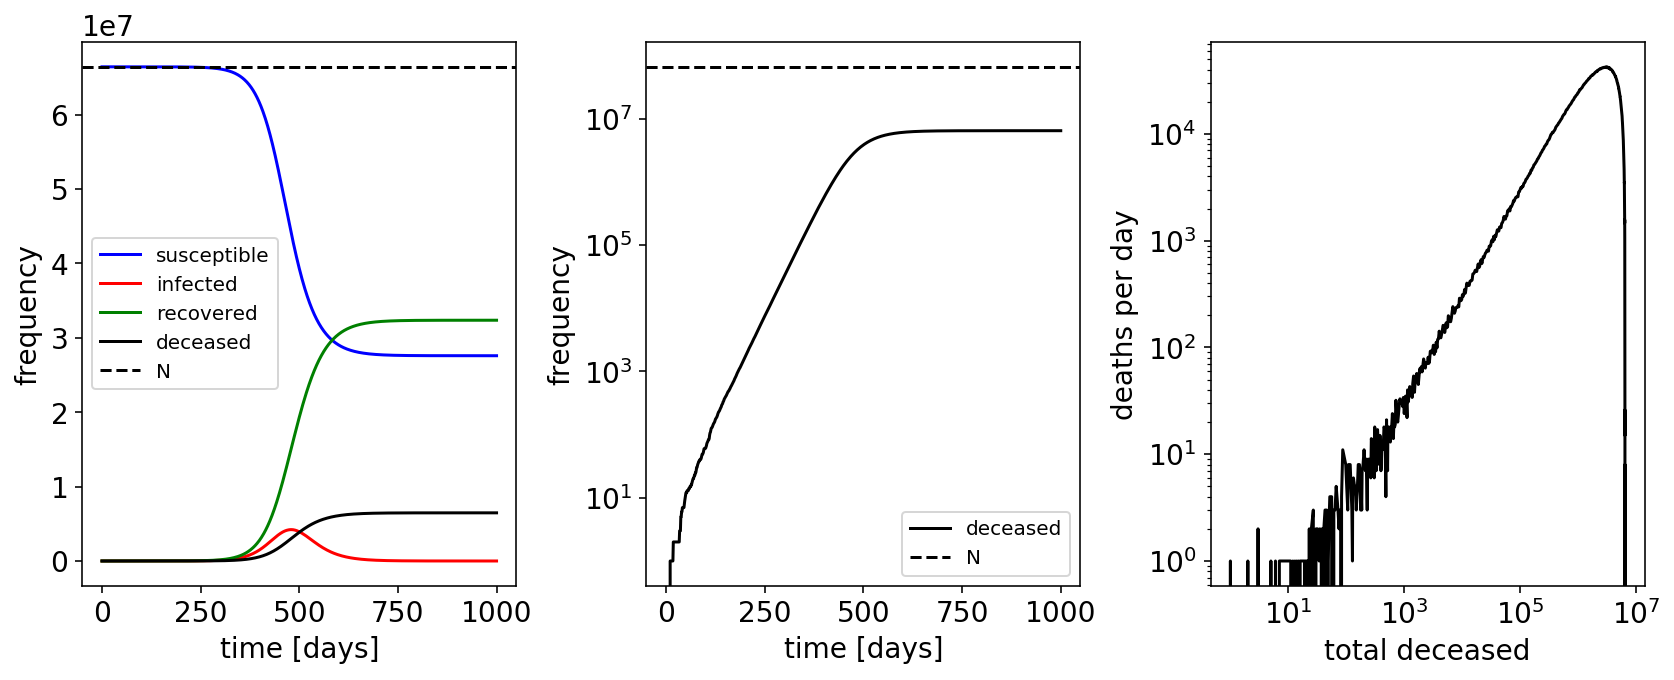

In [5]:
N = 66_440_000
max_timesteps = 1000
initial_infected = 10

# params = (α, β, γ, N)
params = (0.09, 0.05, 0.01, N)
state = set_intial_state(N, initial_infected)

for _ in range(max_timesteps):
    state = timestep(state, params)

plot(state)

## Run multiple times
This is a stochastic model, and so each time we run it forward from the intial conditions we will get slightly different outcomes. So here we run the module with the same parameters and same starting conditions a number of times to examine the variability in our predictions.

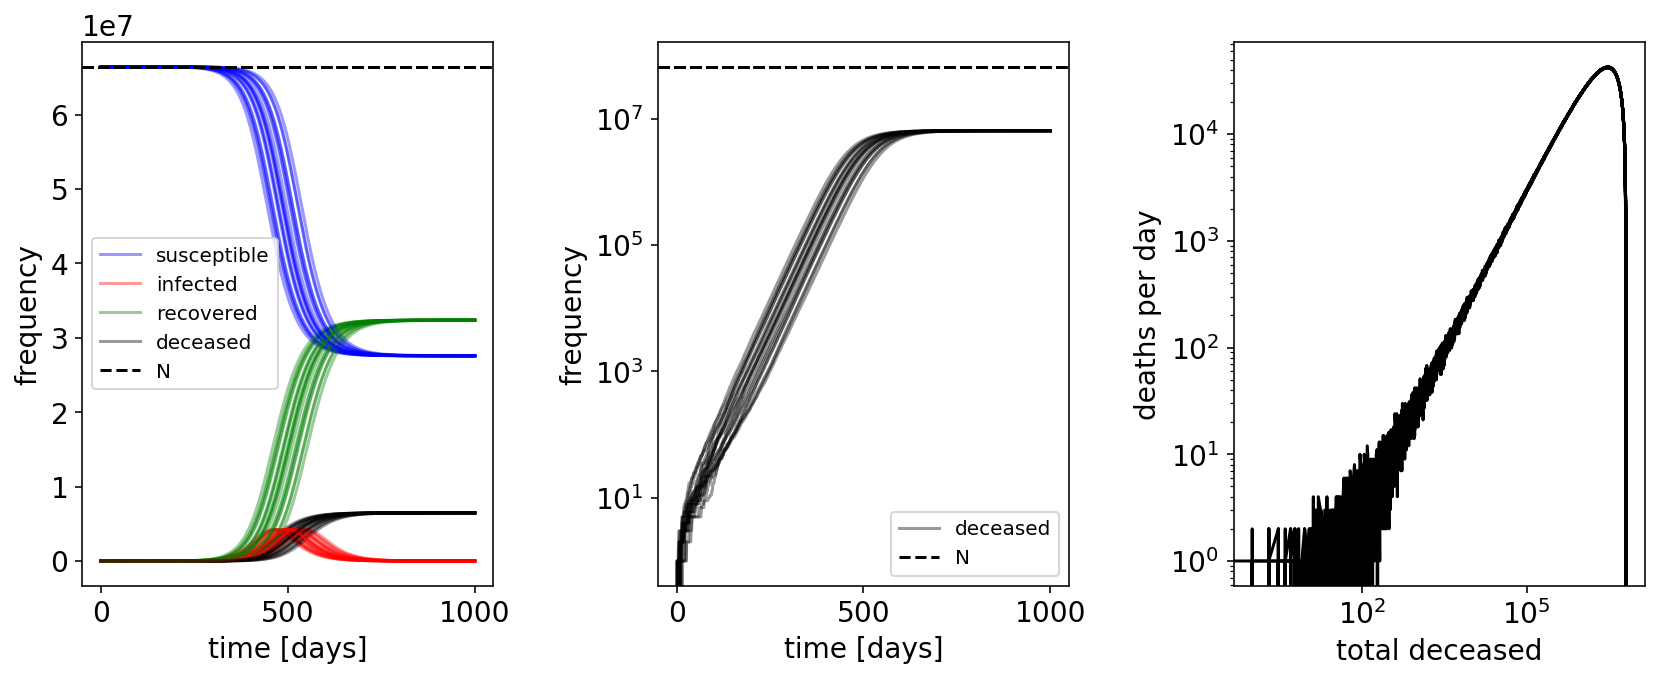

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

n_reps = 20
for rep in range(n_reps):

    # reset to initial state
    state = set_intial_state(N, initial_infected)

    for _ in range(max_timesteps):
        state = timestep(state, params)

    if rep is 0:
        plot(state, ax=ax, legend=True, alpha=0.4)
    else:
        plot(state, ax=ax, legend=False, alpha=0.4)

plt.subplots_adjust(wspace=0.4)